# Recommender Systems 2020/21

### Practice 3 - Content Based recommenders


### Load the data you saw last time:

In [1]:
from urllib.request import urlretrieve
import zipfile, os

# If file exists, skip the download
data_file_path = "data/Movielens_10M/"
data_file_name = data_file_path + "movielens_10m.zip"

# If directory does not exist, create
if not os.path.exists(data_file_path):
    os.makedirs(data_file_path)

if not os.path.exists(data_file_name):
    urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", data_file_name)
    
dataFile = zipfile.ZipFile(data_file_name)
URM_path = dataFile.extract("ml-10M100K/ratings.dat", path="data/Movielens_10M")
URM_file = open(URM_path, 'r')


def rowSplit (rowString):
    
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = float(split[2])
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result


URM_file.seek(0)
URM_tuples = []

for line in URM_file:
   URM_tuples.append(rowSplit (line))

userList, itemList, ratingList, timestampList = zip(*URM_tuples)

userList = list(userList)
itemList = list(itemList)
ratingList = list(ratingList)
timestampList = list(timestampList)


In [2]:
def list_ID_stats(ID_list, label):
    
    min_val = min(ID_list)
    max_val = max(ID_list)
    unique_val = len(set(ID_list))
    missing_val = 1 - unique_val/(max_val - min_val)

    print("{} data, ID: min {}, max {}, unique {}, missig {:.2f} %".format(label, min_val, max_val, unique_val, missing_val*100))

    
    
list_ID_stats(userList, "User")
list_ID_stats(itemList, "Item")

User data, ID: min 1, max 71567, unique 69878, missig 2.36 %
Item data, ID: min 1, max 65133, unique 10677, missig 83.61 %


In [3]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((ratingList, (userList, itemList)))
URM_all = URM_all.tocsr()

### For items in particular most have no interactions. Sometimes it may be better to remove them to avoid creating big data structures with no need. In this case empty columns will nave no impact and we leave them as is. 

## And now load the content informations in the same way:
## In this case we are using tags

In [4]:
ICM_path = dataFile.extract("ml-10M100K/tags.dat", path = "data/Movielens_10M")
ICM_file = open(ICM_path, 'r')

def rowSplit (rowString):
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = str(split[2]) # tag is a string, not a float like the rating
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result

ICM_file.seek(0)
ICM_tuples = []

for line in ICM_file:
    ICM_tuples.append(rowSplit(line))
    
userList_icm, itemList_icm, tagList_icm, timestampList_icm = zip(*ICM_tuples)

userList_icm = list(userList_icm)
itemList_icm = list(itemList_icm)
tagList_icm = list(tagList_icm)
timestampList_icm = list(timestampList_icm)


In [5]:
list_ID_stats(userList_icm, "Users ICM")
list_ID_stats(itemList_icm, "Items ICM")

Users ICM data, ID: min 15, max 71556, unique 4009, missig 94.40 %
Items ICM data, ID: min 1, max 65130, unique 7601, missig 88.33 %


### We can see that most users and items have no data associated to them

In [6]:
numTags = len(set(tagList_icm))

print ("Number of tags\t {}, Number of item-tag tuples {}".format(numTags, len(tagList_icm)))

print("\nData example:")
print(userList_icm[0:10])
print(itemList_icm[0:10])
print(tagList_icm[0:10])

Number of tags	 16529, Number of item-tag tuples 95580

Data example:
[15, 20, 20, 20, 20, 20, 20, 20, 20, 20]
[4973, 1747, 1747, 2424, 2424, 2424, 2947, 2947, 3033, 3033]
['excellent!', 'politics', 'satire', 'chick flick 212', 'hanks', 'ryan', 'action', 'bond', 'spoof', 'star wars']


### The numbers of items and users in the ICM matrix is different from what we saw in the URM, why?

### The tags are string, we should traslate them into numbers so we can use them as indices in the ICM

In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(tagList_icm)

tagList_icm = le.transform(tagList_icm)

print(tagList_icm[0:10])

[ 9814 13375 14131  8515 10769 14070  7015  8071 14829 14900]


# We can now build the ICM

#### Be careful with the indices!

In [8]:
import numpy as np

n_items = URM_all.shape[1]
n_tags = max(tagList_icm) + 1

ICM_shape = (n_items, n_tags)

ones = np.ones(len(tagList_icm))
ICM_all = sps.coo_matrix((ones, (itemList_icm, tagList_icm)), shape = ICM_shape)
ICM_all = ICM_all.tocsr()

ICM_all

<65134x16529 sparse matrix of type '<class 'numpy.float64'>'
	with 71155 stored elements in Compressed Sparse Row format>

# Let's take a look at the ICM

### We leverage CSR and CSC indptr data structure to compute the number of cells that have values for that row or column

In [9]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [10]:
print(features_per_item.shape)
print(items_per_feature.shape)

(65134,)
(16529,)


In [11]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

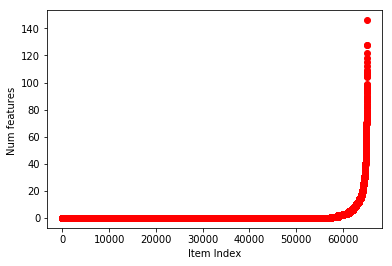

In [12]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Item Index')
pyplot.show()

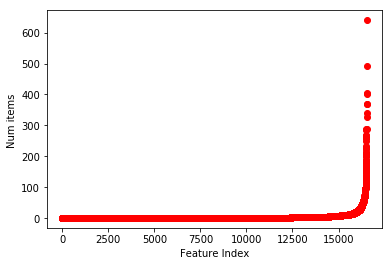

In [13]:
pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Feature Index')
pyplot.show()

# We can now build the recommender algorithm, but first we need the train/test split and the evaluation function:

In [14]:
from Notebooks_utils.data_splitter import train_test_holdout


URM_train, URM_test = train_test_holdout(URM_all, train_perc = 0.8)


from Notebooks_utils.evaluation_function import evaluate_algorithm
from Base.Similarity.Compute_Similarity_Python import Compute_Similarity_Python


In [15]:
class ItemCBFKNNRecommender(object):
    
    def __init__(self, URM, ICM):
        self.URM = URM
        self.ICM = ICM
        
            
    def fit(self, topK=50, shrink=100, normalize = True, similarity = "cosine"):
        
        similarity_object = Compute_Similarity_Python(self.ICM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

### We need to define Cosine similarity... Let's look at the attached source code

### See also a [list of commonly used KNN similarity heuristics](https://github.com/MaurizioFD/RecSys_Course_2018/blob/master/slides/List_of_KNN_similarity_heuristics.pdf)

## A KNN is built with the following steps:
* Compute the similarity of an item with all others
* Select the k-highest similarities

In [16]:
item_id = 50
shrink = 10

The numerator is the dot product of the item features times the whole ICM data transposed

In [18]:
numerator_vector = ICM_all[item_id].dot(ICM_all.T).toarray().ravel()
numerator_vector

array([0., 7., 0., ..., 0., 0., 0.])

In [19]:
item_norms = np.sqrt(np.array(ICM_all.T.power(2).sum(axis=0))).ravel()
item_norms

array([ 0.        , 31.43246729, 10.81665383, ...,  0.        ,
        0.        ,  0.        ])

The denominator will be the product of norms plus the srink term and a small value which prevents the denominator to be zero (only for non-negative data)

In [20]:
denominator_vector = item_norms[item_id] * item_norms + shrink + 1e-6
denominator_vector

array([ 10.000001  , 810.75714271, 285.55943198, ...,  10.000001  ,
        10.000001  ,  10.000001  ])

In [21]:
similarity_vector = numerator_vector/denominator_vector

Let's sort the similarity from the highest to the lowest

In [22]:
sorted_item_indices = np.argsort(-similarity_vector)
sorted_item_indices

array([   50,  6187,  1625, ..., 22743, 22745, 65133], dtype=int64)

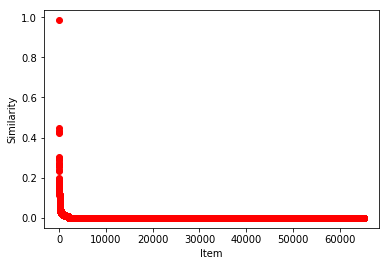

In [23]:
pyplot.plot(similarity_vector[sorted_item_indices], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

Now we select the k most similar items

In [24]:
k = 100

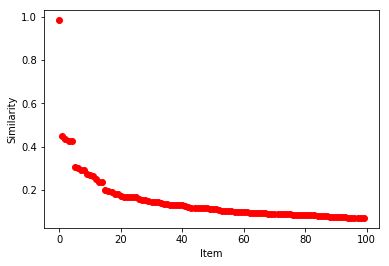

In [25]:
pyplot.plot(similarity_vector[sorted_item_indices[0:k]], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

The operation is performed for all items.
A simple strategy to perform it efficiently is to vectorize the most computationally intensive part, the dot product, on a group of items. The speedup can be of a factor of 10-100.
This strategy is limited by the fact that the result of the dot product is a huge item-item dense similarity which likely does not fit in memory.

In [26]:
import traceback

try:
    numerator_matrix = ICM_all.dot(ICM_all.T).toarray()
    
except Exception as e:
    traceback.print_exc()
    

Traceback (most recent call last):
  File "<ipython-input-26-898ccb95d904>", line 4, in <module>
    numerator_matrix = ICM_all.dot(ICM_all.T).toarray()
  File "C:\ProgramData\Anaconda3\envs\DLevaluation_cpu\lib\site-packages\scipy\sparse\compressed.py", line 962, in toarray
    out = self._process_toarray_args(order, out)
  File "C:\ProgramData\Anaconda3\envs\DLevaluation_cpu\lib\site-packages\scipy\sparse\base.py", line 1187, in _process_toarray_args
    return np.zeros(self.shape, dtype=self.dtype, order=order)
MemoryError


The solution is:
* Compute the numerator a block of items at a time leveraging vectorization while not running out of memory
* Extract the k-nn on those items
* Built incrementally the sparse similarity matrix

In [49]:
block_size = 100

numerator_block = ICM_all[0:block_size].dot(ICM_all.T).toarray()
numerator_block.shape

(100, 65134)

Let's compare the speed to compute the dot product on the whole similarity of the two strategies

In [51]:
import time

n_items = ICM_all.shape[0]

start_time = time.time()

for n_item in range(n_items):
    numerator_vector = ICM_all[item_id].dot(ICM_all.T).toarray().ravel()
    
end_time = time.time()

print("Computing the similarity one item at a time runs at {:.2f} items/sec".format(n_items/(end_time-start_time)))



Computing the similarity one item at a time runs at 760.02 items/sec


In [55]:
n_items = ICM_all.shape[0]

start_time = time.time()

block_size = 100
blocks_start_positions = range(0, n_items, block_size)

numerator_block = ICM_all[0:block_size].dot(ICM_all.T).toarray()

for start_pos in blocks_start_positions:
    end_pos = min(start_pos + block_size, n_items)
    
    numerator_block = ICM_all[start_pos:end_pos].dot(ICM_all.T).toarray()
    
end_time = time.time()

print("Computing the similarity in blocks of 100 items at a time runs at {:.2f} items/sec".format(n_items/(end_time-start_time)))



Computing the similarity in blocks of 100 item at a time runs at 51243.33 items/sec


### In this case the vectorized implementation runs >60 times faster!

#### Usually most of the speed gain comes with blocks of 100 or so items, depending on the system. Much higher than that tends to not be beneficial while requiring increasingly more memory.

## Test our CBF recommender:

In [16]:
recommender = ItemCBFKNNRecommender(URM_train, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 28900 ( 44 % ), 959.58 column/sec, elapsed time 0.50 min
Similarity column 56100 ( 86 % ), 932.43 column/sec, elapsed time 1.00 min
Similarity column 65134 ( 100 % ), 941.12 column/sec, elapsed time 1.15 min


In [17]:
userList_unique = list(set(userList_icm))
for user_id in userList_unique[0:10]:
    print(recommender.recommend(user_id, at=5))

[8636  153 6333  592 1591]
[1036  153 8636 1591 5378]
[65133 21706 21719 21718 21717]
[ 6350 62336  5971  2810  5378]
[1026 8525 2043 2566 5651]
[65133 21706 21719 21718 21717]
[65133 21706 21719 21718 21717]
[ 260 1196   22 2461 8525]
[41566  3086  4901  1619  4161]
[65133 21706 21719 21718 21717]


#### Let's talk about speed

#### Time to compute recommendations for a fixed group of users

In [18]:
import time

n_users_to_test = 1000

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))


Reasonable implementation speed is 407.76 usr/sec


### Let's add a common mistake.... a CSC URM

In [19]:
URM_train_csc = URM_train.tocsc()

recommender = ItemCBFKNNRecommender(URM_train_csc, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 29000 ( 45 % ), 966.19 column/sec, elapsed time 0.50 min
Similarity column 57300 ( 88 % ), 954.67 column/sec, elapsed time 1.00 min
Similarity column 65134 ( 100 % ), 941.27 column/sec, elapsed time 1.15 min


In [20]:
import time, traceback

try:

    n_users_to_test = 1000

    start_time = time.time()

    for user_id in range(n_users_to_test):
        recommender.recommend(user_id, at=5)

    end_time = time.time()

    print("Wrong implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))

    
except Exception as e:
        
    print("Exception {}".format(str(e)))
    traceback.print_exc()


Exception index 65135 is out of bounds for axis 0 with size 65134


Traceback (most recent call last):
  File "<ipython-input-20-cd8883de5544>", line 10, in <module>
    recommender.recommend(user_id, at=5)
  File "<ipython-input-15-d625b194ca44>", line 23, in recommend
    scores = self.filter_seen(user_id, scores)
  File "<ipython-input-15-d625b194ca44>", line 38, in filter_seen
    scores[user_profile] = -np.inf
IndexError: index 65135 is out of bounds for axis 0 with size 65134


## Parameter tuning

#### Once we have built our model we can play with its parameters
* Number of neighbors
* Shrinkage
* Similarity type

#### Number of neighbors

In [21]:
x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender = ItemCBFKNNRecommender(URM_train, ICM_all)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_dict = evaluate_algorithm(URM_test, recommender)
    MAP_per_k.append(result_dict["MAP"])

Similarity column 27500 ( 42 % ), 914.30 column/sec, elapsed time 0.50 min
Similarity column 55100 ( 85 % ), 916.06 column/sec, elapsed time 1.00 min
Similarity column 65134 ( 100 % ), 917.65 column/sec, elapsed time 1.18 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.0924, Recall = 0.0203, MAP = 0.0612
Similarity column 19100 ( 29 % ), 634.86 column/sec, elapsed time 0.50 min
Similarity column 38500 ( 59 % ), 639.12 column/sec, elapsed time 1.00 min
Similarity column 58400 ( 90 % ), 646.91 column/sec, elapsed time 1.50 min
Similarity column 65134 ( 100 % ), 654.12 column/sec, elapsed time 1.66 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated use

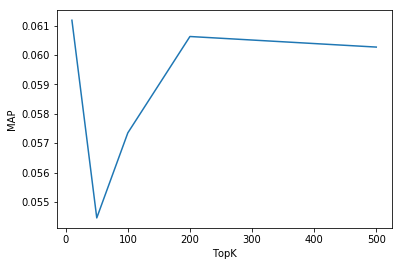

In [22]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

#### On this dataset the number of neighbors does not have a great impact on MAP. Higher values of TopK might work even better

#### Different datasets will behave in different ways.

### Shrinkage

In [23]:
x_tick = [0, 10, 50, 100, 200, 500]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = ItemCBFKNNRecommender(URM_train, ICM_all)
    recommender.fit(shrink=shrink, topK=100)
    
    result_dict = evaluate_algorithm(URM_test, recommender)
    MAP_per_shrinkage.append(result_dict["MAP"])

Similarity column 23000 ( 35 % ), 766.49 column/sec, elapsed time 0.50 min
Similarity column 46100 ( 71 % ), 767.47 column/sec, elapsed time 1.00 min
Similarity column 65134 ( 100 % ), 741.87 column/sec, elapsed time 1.46 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.0816, Recall = 0.0179, MAP = 0.0574
Similarity column 22300 ( 34 % ), 742.80 column/sec, elapsed time 0.50 min
Similarity column 44700 ( 69 % ), 744.63 column/sec, elapsed time 1.00 min
Similarity column 65134 ( 100 % ), 739.30 column/sec, elapsed time 1.47 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 7156

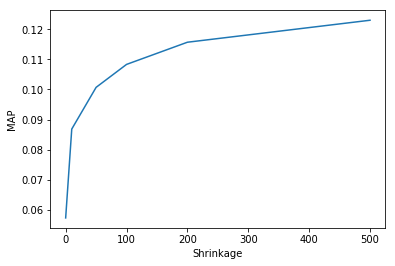

In [24]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

#### The shrinkage value (i.e. support) have a much stronger impact. Combine a parameter search with the two to ensure maximum recommendation quality

## Be careful, overfitting!

#### While a thorough parameter tuning might result in significantly higher MAP on your validation split, it could have only marginally better or even worse MAP on the test set

# Feature weighting

# IDF

![title](https://www.link-assistant.com/images/news/tf-idf-tool-for-seo/screen-03.png)

In [25]:
num_tot_items = ICM_all.shape[0]

# let's count how many items have a certain feature
items_per_feature = (ICM_all > 0).sum(axis=0)

IDF = np.array(np.log(num_tot_items / items_per_feature))[0]

print(ICM_all.shape)
print(IDF.shape)

(65134, 16529)
(16529,)


In [26]:
ICM_idf = ICM_all.copy()
# compute the number of non-zeros in each col
# NOTE: this works only if X is instance of sparse.csc_matrix
col_nnz = np.diff(sps.csc_matrix(ICM_idf).indptr)
print(col_nnz.shape)
print(ICM_idf.shape)
print(IDF.shape)
# then normalize the values in each col
ICM_idf.data *= np.repeat(IDF, col_nnz)

(16529,)
(65134, 16529)
(16529,)


In [27]:
recommender_idf = ItemCBFKNNRecommender(URM_train, ICM_idf)
recommender_idf.fit(shrink=0.0, topK=50)

evaluate_algorithm(URM_test, recommender_idf)

Similarity column 20900 ( 32 % ), 693.43 column/sec, elapsed time 0.50 min
Similarity column 40700 ( 62 % ), 675.35 column/sec, elapsed time 1.00 min
Similarity column 61000 ( 94 % ), 675.22 column/sec, elapsed time 1.51 min
Similarity column 65134 ( 100 % ), 672.11 column/sec, elapsed time 1.62 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.0792, Recall = 0.0172, MAP = 0.0558


{'precision': 0.0792412281329945,
 'recall': 0.01719270671397733,
 'MAP': 0.05577713464283948}

#### There is  a small gain over the non-weighted ICM. Try other feature weighting methods like BM25...

# BM25

In [28]:
from Base.IR_feature_weighting import okapi_BM_25

ICM_BM25 = ICM_all.copy().astype(np.float32)
ICM_BM25 = okapi_BM_25(ICM_BM25)
ICM_BM25 = ICM_BM25.tocsr()

In [29]:
recommender_bm25 = ItemCBFKNNRecommender(URM_train, ICM_BM25)
recommender_bm25.fit(shrink=0.0, topK=50)

evaluate_algorithm(URM_test, recommender_bm25)

Similarity column 21700 ( 33 % ), 721.95 column/sec, elapsed time 0.50 min
Similarity column 45300 ( 70 % ), 752.51 column/sec, elapsed time 1.00 min
Similarity column 65134 ( 100 % ), 762.50 column/sec, elapsed time 1.42 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.0805, Recall = 0.0180, MAP = 0.0559


{'precision': 0.08049056549706429,
 'recall': 0.017977736637926213,
 'MAP': 0.055879630292923775}

#### Another small gain over TF-IDF

# Unnormalized similarity matrix

In [30]:
recommender_dot = ItemCBFKNNRecommender(URM_train, ICM_all)
recommender_dot.W_sparse = ICM_all * ICM_all.T

evaluate_algorithm(URM_test, recommender_dot)

Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.1735, Recall = 0.0364, MAP = 0.1333


{'precision': 0.17354327549896595,
 'recall': 0.036350178495898736,
 'MAP': 0.13328965507910867}

## Be careful when you use user tags as content...